# Autoencoders in SciKeras

Autencoders are an approach to use nearual networks to distill data into it's most important features, thereby compressing the data. We will be following the [Keras tutorial](https://blog.keras.io/building-autoencoders-in-keras.html) on the topic, which goes much more in depth and breadth than we will here. You are highly encouraged to check out that tutorial if you want to learn about autoencoders in the general sense.

## Table of contents

* [1. Setup](#1.-Setup)
* [2. Data](#2.-Data)
* [3. Define Keras Model](#3.-Define-Keras-Model)
* [4. Training](#4.-Training)
* [5. Explore Results](#5.-Explore-Results)

## 1. Setup

In [1]:
try:
    import scikeras
except ImportError:
    !python -m pip install scikeras

Silence TensorFlow logging to keep output succinct.

In [2]:
import warnings
from tensorflow import get_logger
get_logger().setLevel('ERROR')
warnings.filterwarnings("ignore", message="Setting the random state for TF")

In [3]:
import numpy as np
from scikeras.wrappers import KerasClassifier, KerasRegressor
from tensorflow import keras

## 2. Data

We load the dataset from the Keras tutorial. The dataset consists of images of cats and dogs.

In [4]:
from tensorflow.keras.datasets import mnist
import numpy as np


(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


## 3. Define Keras Model

We will be defining a very simple autencoder. We define _three_ model building methods:

1. One to build a full end-to-end autoencoder.
2. One to create a model that includes only the encoder portion.
3. One that creates a model that includes only the decoder portion.

The only variable we give our model is the encoding dimensions, which will be a hyperparemter of our final transformer.

In [5]:
from tensorflow import keras


def get_fit_model(encoding_dim: int) -> keras.Model:
    """Get an autoencoder.

    This autoencoder compresses a 28x28 image (784 pixels) down to a feature of length
    `encoding_dim`, and tries to reconstruct the input image from that vector.
    """
    input_img = keras.Input(shape=(784,), name="input")
    encoded = keras.layers.Dense(encoding_dim, activation='relu', name="encoded")(input_img)
    decoded = keras.layers.Dense(784, activation='sigmoid', name="output")(encoded)
    autoencoder_model = keras.Model(input_img, decoded)
    return autoencoder_model

def get_tf_model(fit_model: keras.Model) -> keras.Model:
    """Get an encoder model.

    We do this by extracting the encoding layer from the fitted autoencoder model.
    """
    return keras.Model(fit_model.get_layer("input").input, fit_model.get_layer("encoded").output)

def get_inverse_tf_model(fit_model: keras.Model, encoding_dim: int) -> keras.Model:
    """Get an deencoder model.

    We do this by extracting the deencoding layer from the fitted autoencoder model
    and adding a new Keras input layer.
    """
    encoded_input = keras.Input(shape=(encoding_dim,))
    output = fit_model.get_layer("output")(encoded_input)
    return keras.Model(encoded_input, output)

Next we create a class that that will enable the `transform` and `fit_transform` methods, as well as integrating all three of our models into a single estimator.

In [6]:
from sklearn.base import TransformerMixin, clone
from scikeras.wrappers import BaseWrapper


class KerasTransformer(BaseWrapper, TransformerMixin):
    """A class that enables transform and fit_transform.
    """

    def __init__(self, *args, tf_est: BaseWrapper = None, inv_tf_est: BaseWrapper = None, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.tf_est = tf_est
        self.inv_tf_est = inv_tf_est


    def fit(self, X, sample_weight=None):
        super().fit(X=X, y=X, sample_weight=sample_weight)
        self.tf_est_ = clone(self.tf_est)
        self.inv_tf_est_ = clone(self.inv_tf_est)
        self.tf_est_.set_params(fit_model=self.model_)
        self.inv_tf_est_.set_params(fit_model=self.model_, encoding_dim=self.encoding_dim)
        X = self.feature_encoder_.transform(X)
        self.tf_est_.initialize(X=X)
        X_tf = self.tf_est_.predict(X=X)
        self.inv_tf_est_.initialize(X_tf)
        return self

    def transform(self, X):
        X = self.feature_encoder_.transform(X)
        X_tf = self.tf_est_.predict(X)
        return X_tf
    
    def inverse_transform(self, X_tf):
        X = self.inv_tf_est_.predict(X_tf)
        X = self.feature_encoder_.inverse_transform(X)
        return X

Next, we wrap the Keras Model with Scikeras. Note that for our encoder/decoder estimators, we do not need to provide a loss function since no training will be done. We do however need to have the `fit_model` and `encoding_dim` so that these will be settable by `BaseWrapper.set_params`.

In [7]:
tf_est = BaseWrapper(model=get_tf_model, fit_model=None, verbose=0)
inv_tf_est = BaseWrapper(model=get_inverse_tf_model, fit_model=None, encoding_dim=None, verbose=0)
autoencoder = KerasTransformer(model=get_fit_model, tf_est=tf_est, inv_tf_est=inv_tf_est, loss="binary_crossentropy", encoding_dim=32, epochs=5)

## 4. Training

To train the model, we pass the input images as both the features and the target. This will train the layers to compress the data as accurately as possible between the encoder and decoder. Note that we only pass the `X` parameter, since we defined the mapping `y=X` in `KerasTransformer.fit` above.

In [8]:
_ = autoencoder.fit(X=x_train)

Epoch 1/5


   1/1875 [..............................] - ETA: 16:54 - loss: 0.6936

  28/1875 [..............................] - ETA: 3s - loss: 0.5571   

  57/1875 [..............................] - ETA: 3s - loss: 0.4742

  86/1875 [>.............................] - ETA: 3s - loss: 0.4304

 115/1875 [>.............................] - ETA: 3s - loss: 0.4024

 146/1875 [=>............................] - ETA: 3s - loss: 0.3810

 175/1875 [=>............................] - ETA: 2s - loss: 0.3656

 203/1875 [==>...........................] - ETA: 2s - loss: 0.3534

 228/1875 [==>...........................] - ETA: 2s - loss: 0.3440

 250/1875 [===>..........................] - ETA: 2s - loss: 0.3368

 277/1875 [===>..........................] - ETA: 2s - loss: 0.3288

 304/1875 [===>..........................] - ETA: 2s - loss: 0.3217

 332/1875 [====>.........................] - ETA: 2s - loss: 0.3150

 363/1875 [====>.........................] - ETA: 2s - loss: 0.3083

 393/1875 [=====>........................] - ETA: 2s - loss: 0.3024

 424/1875 [=====>........................] - ETA: 2s - loss: 0.2969

 454/1875 [======>.......................] - ETA: 2s - loss: 0.2920

 485/1875 [======>.......................] - ETA: 2s - loss: 0.2872

 515/1875 [=======>......................] - ETA: 2s - loss: 0.2830

 547/1875 [=======>......................] - ETA: 2s - loss: 0.2788

 573/1875 [========>.....................] - ETA: 2s - loss: 0.2756

 599/1875 [========>.....................] - ETA: 2s - loss: 0.2726

 627/1875 [=========>....................] - ETA: 2s - loss: 0.2695

 653/1875 [=========>....................] - ETA: 2s - loss: 0.2668

 679/1875 [=========>....................] - ETA: 2s - loss: 0.2642

 706/1875 [==========>...................] - ETA: 2s - loss: 0.2616

 734/1875 [==========>...................] - ETA: 2s - loss: 0.2590

 764/1875 [===========>..................] - ETA: 2s - loss: 0.2564

 796/1875 [===========>..................] - ETA: 1s - loss: 0.2537

 827/1875 [============>.................] - ETA: 1s - loss: 0.2513

 858/1875 [============>.................] - ETA: 1s - loss: 0.2489

 889/1875 [=============>................] - ETA: 1s - loss: 0.2467

 920/1875 [=============>................] - ETA: 1s - loss: 0.2445

 951/1875 [==============>...............] - ETA: 1s - loss: 0.2424

 982/1875 [==============>...............] - ETA: 1s - loss: 0.2405

1012/1875 [===============>..............] - ETA: 1s - loss: 0.2386

1043/1875 [===============>..............] - ETA: 1s - loss: 0.2367

1074/1875 [================>.............] - ETA: 1s - loss: 0.2350

1105/1875 [================>.............] - ETA: 1s - loss: 0.2332

1137/1875 [=================>............] - ETA: 1s - loss: 0.2315

1162/1875 [=================>............] - ETA: 1s - loss: 0.2302

1186/1875 [=================>............] - ETA: 1s - loss: 0.2290

1212/1875 [==================>...........] - ETA: 1s - loss: 0.2277

1240/1875 [==================>...........] - ETA: 1s - loss: 0.2264

1269/1875 [===================>..........] - ETA: 1s - loss: 0.2250

1294/1875 [===================>..........] - ETA: 1s - loss: 0.2239

1320/1875 [====================>.........] - ETA: 0s - loss: 0.2227

1345/1875 [====================>.........] - ETA: 0s - loss: 0.2216

1375/1875 [=====================>........] - ETA: 0s - loss: 0.2203

1403/1875 [=====================>........] - ETA: 0s - loss: 0.2192

1427/1875 [=====================>........] - ETA: 0s - loss: 0.2182

1455/1875 [======================>.......] - ETA: 0s - loss: 0.2171

1486/1875 [======================>.......] - ETA: 0s - loss: 0.2159

1517/1875 [=======================>......] - ETA: 0s - loss: 0.2148

1548/1875 [=======================>......] - ETA: 0s - loss: 0.2136

1579/1875 [========================>.....] - ETA: 0s - loss: 0.2125

1610/1875 [========================>.....] - ETA: 0s - loss: 0.2114

1641/1875 [=========================>....] - ETA: 0s - loss: 0.2104

1671/1875 [=========================>....] - ETA: 0s - loss: 0.2094

1701/1875 [==========================>...] - ETA: 0s - loss: 0.2084

1731/1875 [==========================>...] - ETA: 0s - loss: 0.2074

1761/1875 [===========================>..] - ETA: 0s - loss: 0.2065

1792/1875 [===========================>..] - ETA: 0s - loss: 0.2056

1822/1875 [============================>.] - ETA: 0s - loss: 0.2047

1847/1875 [============================>.] - ETA: 0s - loss: 0.2039

1875/1875 [==============================] - ETA: 0s - loss: 0.2031

1875/1875 [==============================] - 4s 2ms/step - loss: 0.2031


Epoch 2/5
   1/1875 [..............................] - ETA: 2s - loss: 0.1228

  29/1875 [..............................] - ETA: 3s - loss: 0.1105

  61/1875 [..............................] - ETA: 3s - loss: 0.1097

  92/1875 [>.............................] - ETA: 2s - loss: 0.1095

 123/1875 [>.............................] - ETA: 2s - loss: 0.1093

 155/1875 [=>............................] - ETA: 2s - loss: 0.1092

 187/1875 [=>............................] - ETA: 2s - loss: 0.1092

 219/1875 [==>...........................] - ETA: 2s - loss: 0.1091

 251/1875 [===>..........................] - ETA: 2s - loss: 0.1090

 283/1875 [===>..........................] - ETA: 2s - loss: 0.1089

 315/1875 [====>.........................] - ETA: 2s - loss: 0.1089

 347/1875 [====>.........................] - ETA: 2s - loss: 0.1088

 379/1875 [=====>........................] - ETA: 2s - loss: 0.1087

 411/1875 [=====>........................] - ETA: 2s - loss: 0.1087

 443/1875 [======>.......................] - ETA: 2s - loss: 0.1086

 471/1875 [======>.......................] - ETA: 2s - loss: 0.1085

 501/1875 [=======>......................] - ETA: 2s - loss: 0.1085

 530/1875 [=======>......................] - ETA: 2s - loss: 0.1084

 559/1875 [=======>......................] - ETA: 2s - loss: 0.1084

 585/1875 [========>.....................] - ETA: 2s - loss: 0.1083

 609/1875 [========>.....................] - ETA: 2s - loss: 0.1083

 639/1875 [=========>....................] - ETA: 2s - loss: 0.1082

 669/1875 [=========>....................] - ETA: 2s - loss: 0.1081

 699/1875 [==========>...................] - ETA: 1s - loss: 0.1081

 728/1875 [==========>...................] - ETA: 1s - loss: 0.1080

 758/1875 [===========>..................] - ETA: 1s - loss: 0.1080

 788/1875 [===========>..................] - ETA: 1s - loss: 0.1079

 819/1875 [============>.................] - ETA: 1s - loss: 0.1078

 849/1875 [============>.................] - ETA: 1s - loss: 0.1078

 880/1875 [=============>................] - ETA: 1s - loss: 0.1077

 910/1875 [=============>................] - ETA: 1s - loss: 0.1077

 941/1875 [==============>...............] - ETA: 1s - loss: 0.1076

 971/1875 [==============>...............] - ETA: 1s - loss: 0.1075

1002/1875 [===============>..............] - ETA: 1s - loss: 0.1075

1032/1875 [===============>..............] - ETA: 1s - loss: 0.1074

1063/1875 [================>.............] - ETA: 1s - loss: 0.1074

1094/1875 [================>.............] - ETA: 1s - loss: 0.1073

1125/1875 [=================>............] - ETA: 1s - loss: 0.1073

1156/1875 [=================>............] - ETA: 1s - loss: 0.1072

1187/1875 [=================>............] - ETA: 1s - loss: 0.1071

1218/1875 [==================>...........] - ETA: 1s - loss: 0.1071

1249/1875 [==================>...........] - ETA: 1s - loss: 0.1070

1280/1875 [===================>..........] - ETA: 0s - loss: 0.1070

1310/1875 [===================>..........] - ETA: 0s - loss: 0.1069

1341/1875 [====================>.........] - ETA: 0s - loss: 0.1069

1372/1875 [====================>.........] - ETA: 0s - loss: 0.1068

1396/1875 [=====================>........] - ETA: 0s - loss: 0.1068

1425/1875 [=====================>........] - ETA: 0s - loss: 0.1067

1448/1875 [======================>.......] - ETA: 0s - loss: 0.1067

1471/1875 [======================>.......] - ETA: 0s - loss: 0.1066

1500/1875 [=======================>......] - ETA: 0s - loss: 0.1066

1532/1875 [=======================>......] - ETA: 0s - loss: 0.1065

1561/1875 [=======================>......] - ETA: 0s - loss: 0.1065

1592/1875 [========================>.....] - ETA: 0s - loss: 0.1064

1619/1875 [========================>.....] - ETA: 0s - loss: 0.1064

1645/1875 [=========================>....] - ETA: 0s - loss: 0.1063

1677/1875 [=========================>....] - ETA: 0s - loss: 0.1063

1701/1875 [==========================>...] - ETA: 0s - loss: 0.1063

1730/1875 [==========================>...] - ETA: 0s - loss: 0.1062

1755/1875 [===========================>..] - ETA: 0s - loss: 0.1062

1782/1875 [===========================>..] - ETA: 0s - loss: 0.1061

1806/1875 [===========================>..] - ETA: 0s - loss: 0.1061

1831/1875 [============================>.] - ETA: 0s - loss: 0.1061

1856/1875 [============================>.] - ETA: 0s - loss: 0.1060

1875/1875 [==============================] - 3s 2ms/step - loss: 0.1060


Epoch 3/5
   1/1875 [..............................] - ETA: 3s - loss: 0.0981

  24/1875 [..............................] - ETA: 4s - loss: 0.0981

  53/1875 [..............................] - ETA: 3s - loss: 0.0981

  84/1875 [>.............................] - ETA: 3s - loss: 0.0981

 113/1875 [>.............................] - ETA: 3s - loss: 0.0982

 143/1875 [=>............................] - ETA: 3s - loss: 0.0983

 173/1875 [=>............................] - ETA: 3s - loss: 0.0984

 203/1875 [==>...........................] - ETA: 2s - loss: 0.0984

 233/1875 [==>...........................] - ETA: 2s - loss: 0.0984

 263/1875 [===>..........................] - ETA: 2s - loss: 0.0984

 293/1875 [===>..........................] - ETA: 2s - loss: 0.0984

 323/1875 [====>.........................] - ETA: 2s - loss: 0.0984

 353/1875 [====>.........................] - ETA: 2s - loss: 0.0984

 383/1875 [=====>........................] - ETA: 2s - loss: 0.0984

 413/1875 [=====>........................] - ETA: 2s - loss: 0.0984

 443/1875 [======>.......................] - ETA: 2s - loss: 0.0984

 474/1875 [======>.......................] - ETA: 2s - loss: 0.0984

 505/1875 [=======>......................] - ETA: 2s - loss: 0.0984

 536/1875 [=======>......................] - ETA: 2s - loss: 0.0984

 565/1875 [========>.....................] - ETA: 2s - loss: 0.0984

 592/1875 [========>.....................] - ETA: 2s - loss: 0.0984

 616/1875 [========>.....................] - ETA: 2s - loss: 0.0984

 646/1875 [=========>....................] - ETA: 2s - loss: 0.0984

 678/1875 [=========>....................] - ETA: 2s - loss: 0.0984

 708/1875 [==========>...................] - ETA: 2s - loss: 0.0984

 740/1875 [==========>...................] - ETA: 1s - loss: 0.0984

 771/1875 [===========>..................] - ETA: 1s - loss: 0.0984

 803/1875 [===========>..................] - ETA: 1s - loss: 0.0983

 834/1875 [============>.................] - ETA: 1s - loss: 0.0983

 866/1875 [============>.................] - ETA: 1s - loss: 0.0983

 897/1875 [=============>................] - ETA: 1s - loss: 0.0983

 928/1875 [=============>................] - ETA: 1s - loss: 0.0983

 958/1875 [==============>...............] - ETA: 1s - loss: 0.0983

 989/1875 [==============>...............] - ETA: 1s - loss: 0.0983

1019/1875 [===============>..............] - ETA: 1s - loss: 0.0983

1050/1875 [===============>..............] - ETA: 1s - loss: 0.0982

1080/1875 [================>.............] - ETA: 1s - loss: 0.0982

1110/1875 [================>.............] - ETA: 1s - loss: 0.0982

1141/1875 [=================>............] - ETA: 1s - loss: 0.0982

1171/1875 [=================>............] - ETA: 1s - loss: 0.0982

1201/1875 [==================>...........] - ETA: 1s - loss: 0.0982

1231/1875 [==================>...........] - ETA: 1s - loss: 0.0982

1262/1875 [===================>..........] - ETA: 1s - loss: 0.0982

1293/1875 [===================>..........] - ETA: 0s - loss: 0.0982

1324/1875 [====================>.........] - ETA: 0s - loss: 0.0981

1354/1875 [====================>.........] - ETA: 0s - loss: 0.0981

1385/1875 [=====================>........] - ETA: 0s - loss: 0.0981

1416/1875 [=====================>........] - ETA: 0s - loss: 0.0981

1446/1875 [======================>.......] - ETA: 0s - loss: 0.0981

1477/1875 [======================>.......] - ETA: 0s - loss: 0.0981

1507/1875 [=======================>......] - ETA: 0s - loss: 0.0981

1538/1875 [=======================>......] - ETA: 0s - loss: 0.0981

1569/1875 [========================>.....] - ETA: 0s - loss: 0.0981

1600/1875 [========================>.....] - ETA: 0s - loss: 0.0980

1631/1875 [=========================>....] - ETA: 0s - loss: 0.0980

1662/1875 [=========================>....] - ETA: 0s - loss: 0.0980

1693/1875 [==========================>...] - ETA: 0s - loss: 0.0980

1724/1875 [==========================>...] - ETA: 0s - loss: 0.0980

1755/1875 [===========================>..] - ETA: 0s - loss: 0.0980

1786/1875 [===========================>..] - ETA: 0s - loss: 0.0980

1817/1875 [============================>.] - ETA: 0s - loss: 0.0980

1848/1875 [============================>.] - ETA: 0s - loss: 0.0980

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0980


Epoch 4/5
   1/1875 [..............................] - ETA: 3s - loss: 0.1031

  32/1875 [..............................] - ETA: 2s - loss: 0.0983

  63/1875 [>.............................] - ETA: 2s - loss: 0.0976

  94/1875 [>.............................] - ETA: 2s - loss: 0.0973

 125/1875 [=>............................] - ETA: 2s - loss: 0.0971

 156/1875 [=>............................] - ETA: 2s - loss: 0.0970

 187/1875 [=>............................] - ETA: 2s - loss: 0.0969

 218/1875 [==>...........................] - ETA: 2s - loss: 0.0968

 249/1875 [==>...........................] - ETA: 2s - loss: 0.0968

 280/1875 [===>..........................] - ETA: 2s - loss: 0.0967

 311/1875 [===>..........................] - ETA: 2s - loss: 0.0967

 342/1875 [====>.........................] - ETA: 2s - loss: 0.0967

 373/1875 [====>.........................] - ETA: 2s - loss: 0.0966

 404/1875 [=====>........................] - ETA: 2s - loss: 0.0966

 435/1875 [=====>........................] - ETA: 2s - loss: 0.0966

 466/1875 [======>.......................] - ETA: 2s - loss: 0.0965

 497/1875 [======>.......................] - ETA: 2s - loss: 0.0965

 528/1875 [=======>......................] - ETA: 2s - loss: 0.0965

 559/1875 [=======>......................] - ETA: 2s - loss: 0.0965

 590/1875 [========>.....................] - ETA: 2s - loss: 0.0965

 618/1875 [========>.....................] - ETA: 2s - loss: 0.0964

 648/1875 [=========>....................] - ETA: 2s - loss: 0.0964

 676/1875 [=========>....................] - ETA: 1s - loss: 0.0964

 702/1875 [==========>...................] - ETA: 1s - loss: 0.0964

 723/1875 [==========>...................] - ETA: 1s - loss: 0.0964

 753/1875 [===========>..................] - ETA: 1s - loss: 0.0964

 783/1875 [===========>..................] - ETA: 1s - loss: 0.0964

 814/1875 [============>.................] - ETA: 1s - loss: 0.0964

 845/1875 [============>.................] - ETA: 1s - loss: 0.0964

 876/1875 [=============>................] - ETA: 1s - loss: 0.0964

 907/1875 [=============>................] - ETA: 1s - loss: 0.0963

 935/1875 [=============>................] - ETA: 1s - loss: 0.0963

 966/1875 [==============>...............] - ETA: 1s - loss: 0.0963

 997/1875 [==============>...............] - ETA: 1s - loss: 0.0963

1028/1875 [===============>..............] - ETA: 1s - loss: 0.0963

1059/1875 [===============>..............] - ETA: 1s - loss: 0.0963

1090/1875 [================>.............] - ETA: 1s - loss: 0.0963

1121/1875 [================>.............] - ETA: 1s - loss: 0.0963

1151/1875 [=================>............] - ETA: 1s - loss: 0.0963

1181/1875 [=================>............] - ETA: 1s - loss: 0.0963

1211/1875 [==================>...........] - ETA: 1s - loss: 0.0963

1242/1875 [==================>...........] - ETA: 1s - loss: 0.0963

1273/1875 [===================>..........] - ETA: 1s - loss: 0.0963

1304/1875 [===================>..........] - ETA: 0s - loss: 0.0963

1335/1875 [====================>.........] - ETA: 0s - loss: 0.0963

1366/1875 [====================>.........] - ETA: 0s - loss: 0.0963

1397/1875 [=====================>........] - ETA: 0s - loss: 0.0963

1428/1875 [=====================>........] - ETA: 0s - loss: 0.0963

1459/1875 [======================>.......] - ETA: 0s - loss: 0.0963

1490/1875 [======================>.......] - ETA: 0s - loss: 0.0962

1521/1875 [=======================>......] - ETA: 0s - loss: 0.0962

1552/1875 [=======================>......] - ETA: 0s - loss: 0.0962

1583/1875 [========================>.....] - ETA: 0s - loss: 0.0962

1613/1875 [========================>.....] - ETA: 0s - loss: 0.0962

1644/1875 [=========================>....] - ETA: 0s - loss: 0.0962

1675/1875 [=========================>....] - ETA: 0s - loss: 0.0962

1705/1875 [==========================>...] - ETA: 0s - loss: 0.0962

1736/1875 [==========================>...] - ETA: 0s - loss: 0.0962

1763/1875 [===========================>..] - ETA: 0s - loss: 0.0962

1791/1875 [===========================>..] - ETA: 0s - loss: 0.0962

1818/1875 [============================>.] - ETA: 0s - loss: 0.0962

1844/1875 [============================>.] - ETA: 0s - loss: 0.0962

1871/1875 [============================>.] - ETA: 0s - loss: 0.0962

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0962


Epoch 5/5
   1/1875 [..............................] - ETA: 5s - loss: 0.0977

  26/1875 [..............................] - ETA: 3s - loss: 0.0950

  57/1875 [..............................] - ETA: 3s - loss: 0.0952

  86/1875 [>.............................] - ETA: 3s - loss: 0.0954

 116/1875 [>.............................] - ETA: 3s - loss: 0.0955

 147/1875 [=>............................] - ETA: 2s - loss: 0.0955

 178/1875 [=>............................] - ETA: 2s - loss: 0.0955

 208/1875 [==>...........................] - ETA: 2s - loss: 0.0956

 239/1875 [==>...........................] - ETA: 2s - loss: 0.0956

 270/1875 [===>..........................] - ETA: 2s - loss: 0.0956

 300/1875 [===>..........................] - ETA: 2s - loss: 0.0956

 330/1875 [====>.........................] - ETA: 2s - loss: 0.0956

 360/1875 [====>.........................] - ETA: 2s - loss: 0.0956

 390/1875 [=====>........................] - ETA: 2s - loss: 0.0956

 420/1875 [=====>........................] - ETA: 2s - loss: 0.0956

 451/1875 [======>.......................] - ETA: 2s - loss: 0.0955

 481/1875 [======>.......................] - ETA: 2s - loss: 0.0955

 511/1875 [=======>......................] - ETA: 2s - loss: 0.0955

 541/1875 [=======>......................] - ETA: 2s - loss: 0.0955

 572/1875 [========>.....................] - ETA: 2s - loss: 0.0955

 602/1875 [========>.....................] - ETA: 2s - loss: 0.0955

 633/1875 [=========>....................] - ETA: 2s - loss: 0.0955

 664/1875 [=========>....................] - ETA: 2s - loss: 0.0955

 693/1875 [==========>...................] - ETA: 1s - loss: 0.0955

 723/1875 [==========>...................] - ETA: 1s - loss: 0.0955

 754/1875 [===========>..................] - ETA: 1s - loss: 0.0954

 785/1875 [===========>..................] - ETA: 1s - loss: 0.0954

 815/1875 [============>.................] - ETA: 1s - loss: 0.0954

 846/1875 [============>.................] - ETA: 1s - loss: 0.0954

 877/1875 [=============>................] - ETA: 1s - loss: 0.0954

 908/1875 [=============>................] - ETA: 1s - loss: 0.0954

 939/1875 [==============>...............] - ETA: 1s - loss: 0.0954

 970/1875 [==============>...............] - ETA: 1s - loss: 0.0954

1000/1875 [===============>..............] - ETA: 1s - loss: 0.0954

1030/1875 [===============>..............] - ETA: 1s - loss: 0.0954

1061/1875 [===============>..............] - ETA: 1s - loss: 0.0954

1092/1875 [================>.............] - ETA: 1s - loss: 0.0954

1123/1875 [================>.............] - ETA: 1s - loss: 0.0954

1154/1875 [=================>............] - ETA: 1s - loss: 0.0954

1185/1875 [=================>............] - ETA: 1s - loss: 0.0954

1216/1875 [==================>...........] - ETA: 1s - loss: 0.0954

1247/1875 [==================>...........] - ETA: 1s - loss: 0.0954

1278/1875 [===================>..........] - ETA: 0s - loss: 0.0954

1309/1875 [===================>..........] - ETA: 0s - loss: 0.0954

1340/1875 [====================>.........] - ETA: 0s - loss: 0.0954

1371/1875 [====================>.........] - ETA: 0s - loss: 0.0954

1402/1875 [=====================>........] - ETA: 0s - loss: 0.0954

1433/1875 [=====================>........] - ETA: 0s - loss: 0.0954

1464/1875 [======================>.......] - ETA: 0s - loss: 0.0954

1495/1875 [======================>.......] - ETA: 0s - loss: 0.0954

1525/1875 [=======================>......] - ETA: 0s - loss: 0.0954

1556/1875 [=======================>......] - ETA: 0s - loss: 0.0954

1587/1875 [========================>.....] - ETA: 0s - loss: 0.0954

1618/1875 [========================>.....] - ETA: 0s - loss: 0.0954

1649/1875 [=========================>....] - ETA: 0s - loss: 0.0953

1680/1875 [=========================>....] - ETA: 0s - loss: 0.0953

1710/1875 [==========================>...] - ETA: 0s - loss: 0.0953

1741/1875 [==========================>...] - ETA: 0s - loss: 0.0953

1772/1875 [===========================>..] - ETA: 0s - loss: 0.0953

1803/1875 [===========================>..] - ETA: 0s - loss: 0.0953

1834/1875 [============================>.] - ETA: 0s - loss: 0.0953

1865/1875 [============================>.] - ETA: 0s - loss: 0.0953

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0953


Next, we round trip the test dataset and explore the performance of the autoencoder.

In [9]:
roundtrip_imgs = autoencoder.inverse_transform(autoencoder.transform(x_test))

## 5. Explore Results

Let's compare our inputs to lossy decoded outputs:

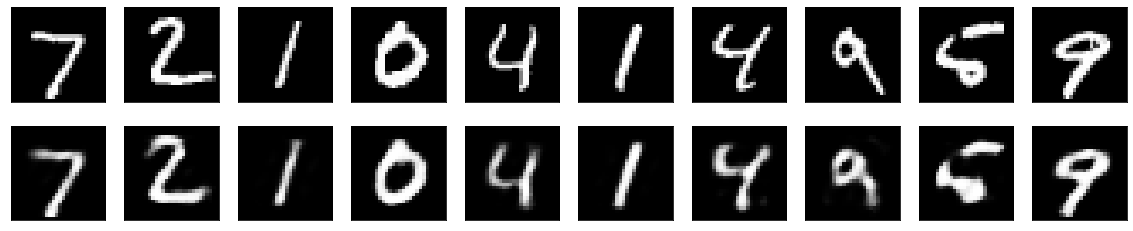

In [10]:
import matplotlib.pyplot as plt


n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(roundtrip_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

What about the compression? Let's check the sizes of the arrays.

In [11]:
encoded_imgs = autoencoder.transform(x_test)
print(f"x_test.shape[1]: {x_test.shape[1]}")
print(f"encoded_imgs.shape[1]: {encoded_imgs.shape[1]}")
cr = round((encoded_imgs.nbytes/x_test.nbytes), 2)
print(f"Compression ratio: 1/{1/cr:.0f}")

x_test.shape[1]: 784
encoded_imgs.shape[1]: 32
Compression ratio: 1/25
